In [21]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = 16, 9
plt.rcParams['lines.linewidth'] = 1.5

font = {'weight' : 'normal',
      'size'   : 12}

plt.rc('font', **font)

import fair
fair.__version__

'1.0.1'

C:\Users\leach_000\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:26: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.



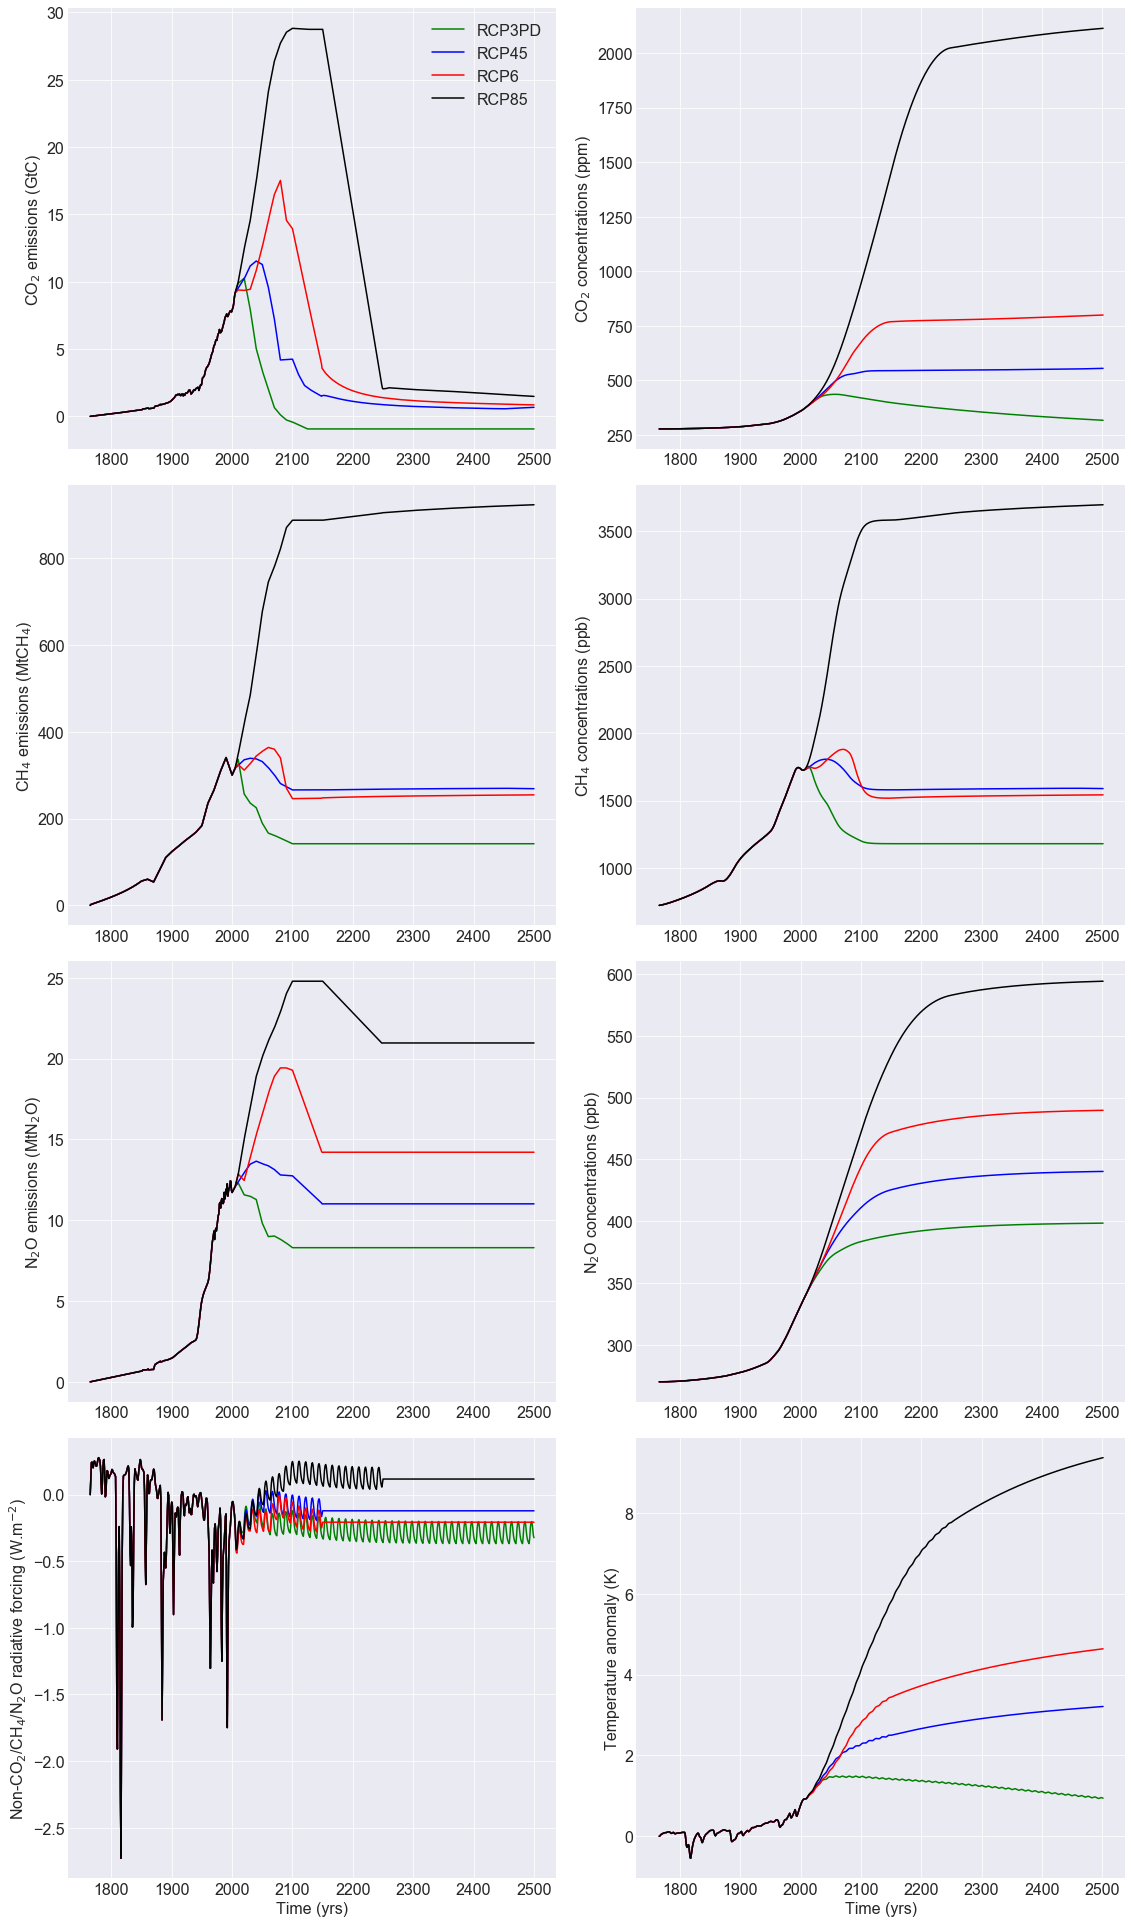

In [29]:
fig = plt.figure(figsize=(16,27))
ax1 = fig.add_subplot(421)
ax2 = fig.add_subplot(422)
ax3 = fig.add_subplot(423)
ax4 = fig.add_subplot(424)
ax5 = fig.add_subplot(425)
ax6 = fig.add_subplot(426)
ax7 = fig.add_subplot(427)
ax8 = fig.add_subplot(428)

rcps = ['RCP3PD','RCP45','RCP6','RCP85']
colours = ['green','blue','red','black']

for i,rcp in enumerate(rcps):
    emms_file = './fair/RCPs/' + rcp + '_EMISSIONS.csv'
    emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)
    emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
    M_emissions = emms_data['CH4']
    N_emissions = emms_data['N2O'] * 44.0 / 28.0 # In RCPs, given in MtN emissions, not MtN2O
    
    forc_file = './fair/RCPs/' + rcp + '_MIDYEAR_RADFORCING.csv'
    forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)
    other_rf = forc_data['TOTAL_INCLVOLCANIC_RF'] - forc_data['CO2_RF'] - forc_data['CH4_RF'] - forc_data['N2O_RF']
    
    C,T,RF,M,N,MK_gas,df,tau = fair.forward.fair_scm(emissions=emissions,M_emissions=M_emissions,N_emissions=N_emissions,
                            other_rf=other_rf,m0 = 11.2,tau_N = 121)
    
    fair.forward.plot_fair(emissions,M_emissions,N_emissions,
              C,M,N,
              other_rf,
              T,
              y_0=1765,
              tuts='yrs',
              infig=fig,
              inemmsax=ax1,
              inconcax=ax2,
              inM_emmsax=ax3,
              inM_concax=ax4,
              inN_emmsax=ax5,
              inN_concax=ax6,
              inforcax=ax7,
              intempax=ax8,
              colour={'emms':colours[i],
                     'conc':colours[i],
                     'forc':colours[i],
                     'temp':colours[i]},
              label=rcp
             )

In [3]:
# GWP calculation of Methane and N2O

from scipy.integrate import trapz as numint

# AGWP Calculation

#CO2 RF computation

emissions = np.zeros(502)
emissions[0] = 1.0 * 12 / 44 # Convert 1 GtCO2 into GtC
C,T,RFCO2,M,N,MK_gas = fair.forward.fair_scm(emissions=emissions,F_2x=3.7083,C_0=390.5,M_0=1803,N_0=324.2)

#Methane RF computation

M_emissions = np.zeros(502)
M_emissions[0] = 1000. # 1 GtCH4
C,T,RFCH4,M,N,MK_gas = fair.forward.fair_scm(emissions=np.zeros(502),M_emissions=M_emissions,F_2x=3.7083,C_0=390.5,M_0=1803,N_0=324.2)

#Methane RF computation

N_emissions = np.zeros(502)
N_emissions[0] = 1000. # 1 GtN2O
C,T,RFN2O,M,N,MK_gas = fair.forward.fair_scm(emissions=np.zeros(502),N_emissions=N_emissions,F_2x=3.7083,C_0=390.5,M_0=1803,N_0=324.2)

AGWPCO2 = np.zeros(502)
AGWPCH4 = np.zeros(502)
AGWPN2O = np.zeros(502)

for i in range(1,502):
    AGWPCO2[i] = numint(RFCO2[:i])
    AGWPCH4[i] = numint(RFCH4[:i])
    AGWPN2O[i] = numint(RFN2O[:i])
    
GWPCH4 = AGWPCH4 / AGWPCO2
GWPN2O = AGWPN2O / AGWPCO2

#fig = plt.figure()
#plt.plot(AGWPCO2)
#plt.plot(AGWPCH4 * 0.1)
#fig1 = plt.figure()
#plt.plot(AGWPN2O)

print ''
print "CH4 GWPs [20 yrs, 100 yrs, 500yrs]"
print [GWPCH4[21],GWPCH4[101],GWPCH4[501]]
print ''
print "N2O GWPs [20 yrs, 100 yrs, 500yrs]"
print [GWPN2O[21],GWPN2O[101],GWPN2O[501]]


CH4 GWPs [20 yrs, 100 yrs, 500yrs]
[75.641768667535828, 27.268751923103139, 7.3214978715334]

N2O GWPs [20 yrs, 100 yrs, 500yrs]
[395.97250796767423, 431.23460112323579, 206.9881300414701]


C:\Users\leach_000\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:34: RuntimeWarning: invalid value encountered in divide
C:\Users\leach_000\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:35: RuntimeWarning: invalid value encountered in divide


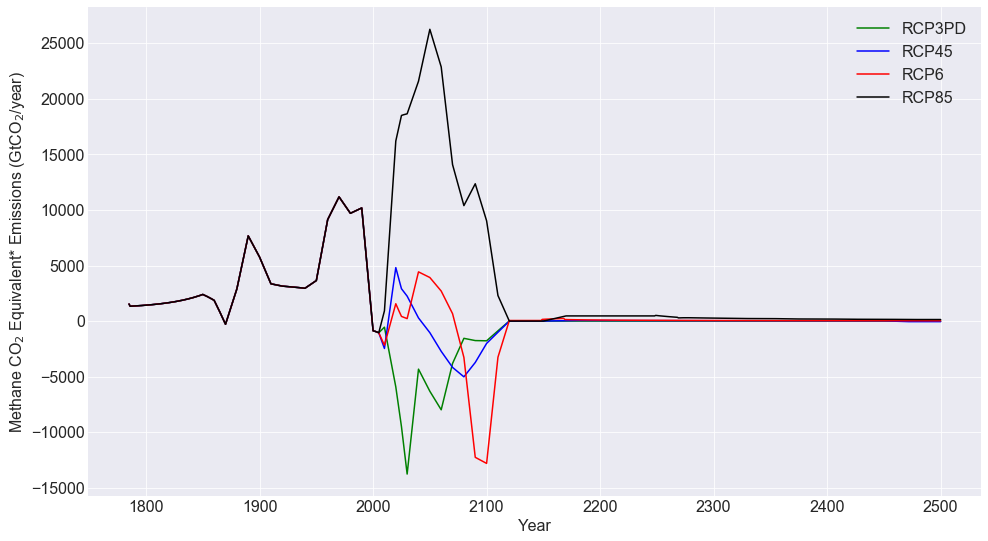

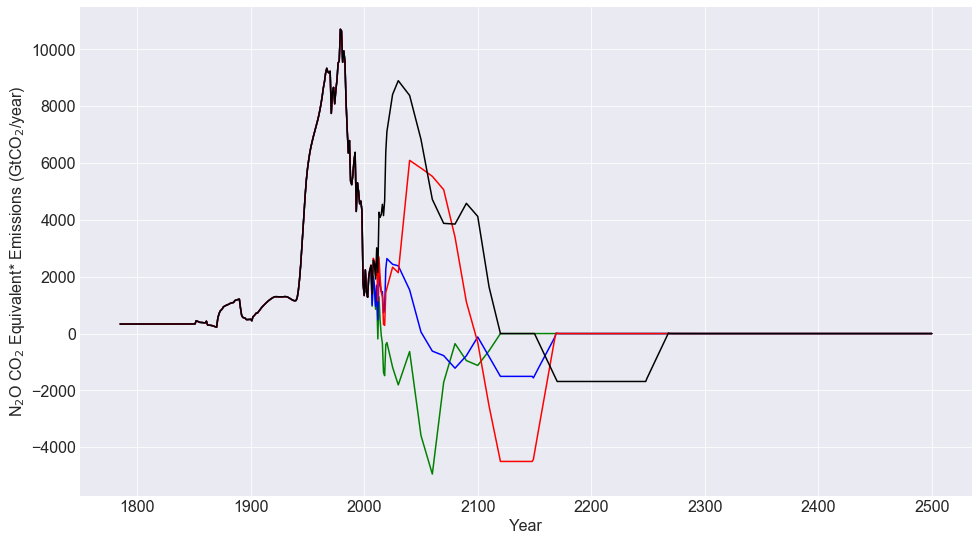

In [4]:
# CO2_e* Computation for RCP3

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111) 

rcps = ['RCP3PD','RCP45','RCP6','RCP85']
colours = ['green','blue','red','black']
time = np.arange(1765+20,2501)

for i,rcp in enumerate(rcps):
    emms_file = './fair/RCPs/' + rcp + '_EMISSIONS.csv'
    emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)
    emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
    M_emissions = emms_data['CH4']
    N_emissions = emms_data['N2O'] * 44.0 / 28.0 # In RCPs, given in MtN emissions, not MtN2O
   
    [deltaCH4,deltaN2O] = [np.zeros(len(emissions)-20),np.zeros(len(emissions)-20)]

    for ii in range(20,len(emissions)):
        deltaCH4[ii-20] = M_emissions[ii]-M_emissions[ii-20]
        deltaN2O[ii-20] = N_emissions[ii]-N_emissions[ii-20]
    
    CO2_e_star_CH4 = deltaCH4 / 20.0 * GWPCH4[101] * 100
    CO2_e_star_N2O = deltaN2O / 20.0 * GWPN2O[101] * 100

    ax1.plot(time,CO2_e_star_CH4,color=colours[i],label=rcps[i])
    ax1.set_ylabel('Methane CO$_2$ Equivalent* Emissions (GtCO$_2$/year)')
    ax1.set_xlabel('Year')
    ax1.legend(loc='best')

    ax2.plot(time,CO2_e_star_N2O,color=colours[i],label=rcps[i])
    ax2.set_ylabel('N$_2$O CO$_2$ Equivalent* Emissions (GtCO$_2$/year)')
    ax2.set_xlabel('Year')

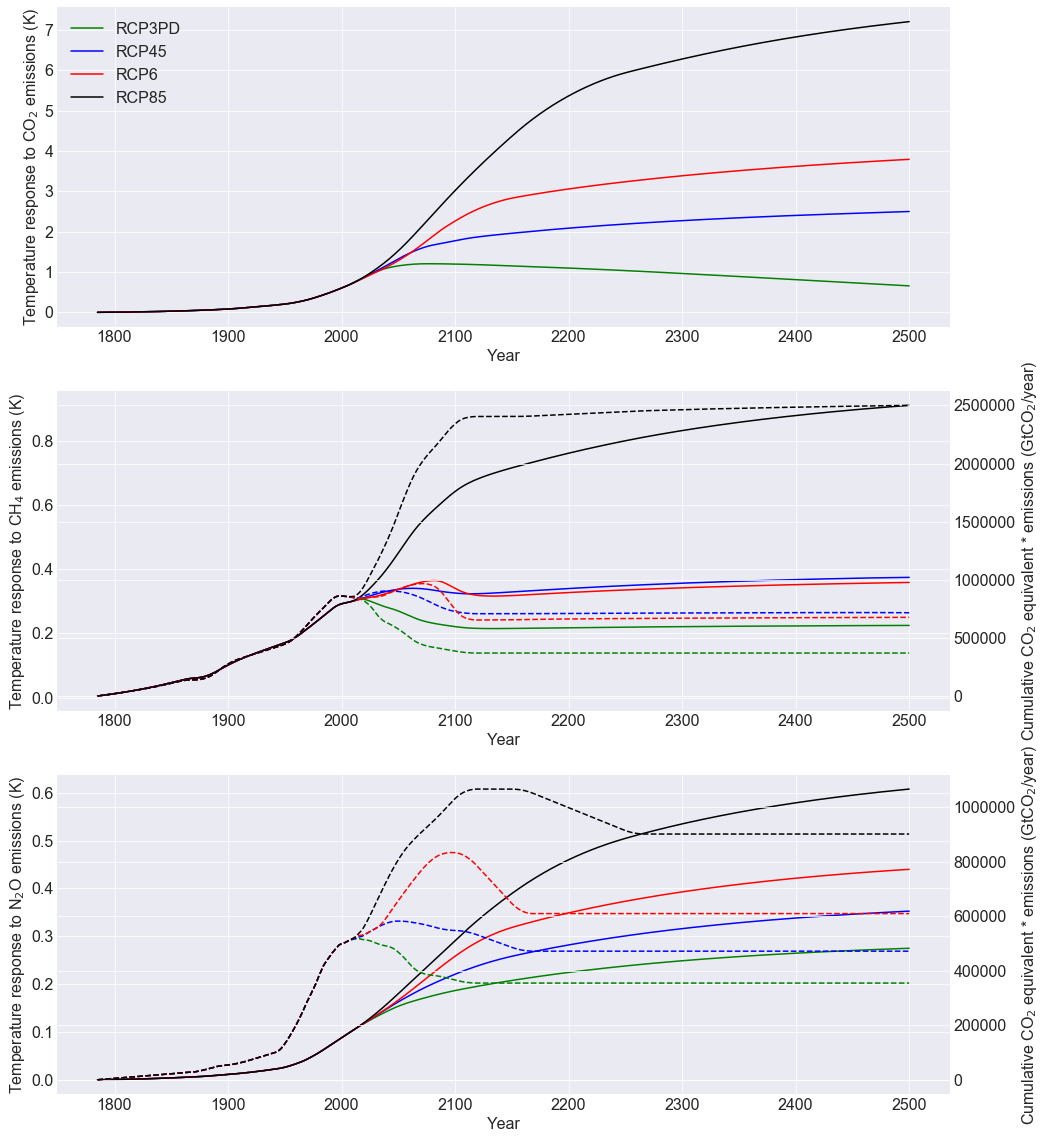

In [5]:
# Temperature response to these forcings

fig1 = plt.figure(figsize=(16,20))
ax1 = fig1.add_subplot(311)
ax2 = fig1.add_subplot(312)
ax3 = fig1.add_subplot(313)
ax4 = ax2.twinx()
ax5 = ax3.twinx()

time = np.arange(1785,2501)

rcps = ['RCP3PD','RCP45','RCP6','RCP85']
colours = ['green','blue','red','black']

for i,rcp in enumerate(rcps):
    emms_file = './fair/RCPs/' + rcp + '_EMISSIONS.csv'
    emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)
    emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
    M_emissions = emms_data['CH4']
    N_emissions = emms_data['N2O'] * 44.0 / 28.0 # In RCPs, given in MtN emissions, not MtN2O

    C,T_CO2,RF,M,N = fair.forward.fair_scm(emissions=emissions)
    C,T_CH4,RF,M,N = fair.forward.fair_scm(emissions = np.zeros(len(emissions)),M_emissions=M_emissions)
    C,T_N2O,RF,M,N = fair.forward.fair_scm(emissions = np.zeros(len(emissions)),N_emissions=N_emissions)
    
    ax1.plot(time,T_CO2[20:],color=colours[i],label=rcps[i])
    ax1.set_ylabel('Temperature response to CO$_2$ emissions (K)')
    ax1.set_xlabel('Year')
    ax1.legend(loc='best')

    ax2.plot(time,T_CH4[20:],color=colours[i],label=rcps[i])
    ax2.set_ylabel('Temperature response to CH$_4$ emissions (K)')
    ax2.set_xlabel('Year')

    ax3.plot(time,T_N2O[20:],color=colours[i],label=rcps[i])
    ax3.set_ylabel('Temperature response to N$_2$O emissions (K)')
    ax3.set_xlabel('Year')
    
    for ii in range(20,len(emissions)):
        deltaCH4[ii-20] = M_emissions[ii]-M_emissions[ii-20]
        deltaN2O[ii-20] = N_emissions[ii]-N_emissions[ii-20]
    
    CO2_e_star_CH4 = deltaCH4 / 20.0 * GWPCH4[101] * 100.
    CO2_e_star_N2O = deltaN2O / 20.0 * GWPN2O[101] * 100.
    
    cumCH4eq = np.cumsum(CO2_e_star_CH4)
    cumN2Oeq = np.cumsum(CO2_e_star_N2O)
    
    ax4.plot(time,cumCH4eq,'--',color=colours[i],label=rcps[i])
    ax4.set_ylabel('Cumulative CO$_2$ equivalent * emissions (GtCO$_2$/year)')
    ax4.set_xlabel('Year')
    
    ax5.plot(time,cumN2Oeq,'--',color=colours[i],label=rcps[i])
    ax5.set_ylabel('Cumulative CO$_2$ equivalent * emissions (GtCO$_2$/year)')
    ax5.set_xlabel('Year')

In [5]:
# GWP calculation as a Perturbation on RCP4.5

from scipy.integrate import trapz as numint

emms_file = './fair/RCPs/RCP45_EMISSIONS.csv'
emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)
emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
M_emissions = emms_data['CH4']
N_emissions = emms_data['N2O'] * 44.0 / 28.0 # In RCPs, given in MtN emissions, not MtN2O

forc_file = './fair/RCPs/RCP45_MIDYEAR_RADFORCING.csv'
forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)
other_rf = forc_data['TOTAL_INCLVOLCANIC_RF'] - forc_data['CO2_RF'] - forc_data['CH4_RF'] - forc_data['N2O_RF']



C_unpert,T_unpert,RF_unpert,M_unpert,N_unpert,MK_gas_unpert,db = fair.forward.fair_scm(emissions=emissions,M_emissions=M_emissions,N_emissions=N_emissions,
                            other_rf=other_rf,tau_N = 100)

# Now we recalculate with a perturbation on CO2 emissions of 1 GtCO_2 at 2015

emissions_pert = emms_data['FossilCO2'] + emms_data['OtherCO2']
emissions_pert[250] = emissions_pert[250] + 1 *10**(-3) * 12.0 / 44.0 # Convert to GtC from GtCO2

C_CO2,T_CO2,RF_CO2,M_CO2,N_CO2,MK_gas_CO2,db = fair.forward.fair_scm(emissions=emissions_pert,M_emissions=M_emissions,N_emissions=N_emissions,
                            other_rf=other_rf,tau_N = 100)

# Perturbation on methane emissions of 1 GtCH4

M_emissions_pert = emms_data['CH4']
M_emissions_pert[250] = M_emissions_pert[250] + 1.0

C_CH4,T_CH4,RF_CH4,M_CH4,N_CH4,MK_gas_CH4,db = fair.forward.fair_scm(emissions=emissions,M_emissions=M_emissions_pert,N_emissions=N_emissions,
                            other_rf=other_rf,tau_N = 100)

# Perturbation on N2O emissions of 1 GtN2O

N_emissions_pert = emms_data['N2O'] * 44.0 / 28.0 # Convert to GtN2O from GtN
N_emissions_pert[250] = N_emissions_pert[250] + 1.0

C_N2O,T_N2O,RF_N2O,M_N2O,N_N2O,MK_gas_N2O,db = fair.forward.fair_scm(emissions=emissions,M_emissions=M_emissions,N_emissions=N_emissions_pert,
                            other_rf=other_rf,tau_N = 100)

# Calculate AGWPs from radiative forcings (perturbed - unperturbed)

[RFCO2,RFCH4,RFN2O] = [RF_CO2,RF_CH4,RF_N2O] - RF_unpert

AGWPCO2 = np.zeros(484)
AGWPCH4 = np.zeros(484)
AGWPN2O = np.zeros(484)

for i in range(251,735):
    
    AGWPCO2[i-251] = numint(RFCO2[:i])
    AGWPCH4[i-251] = numint(RFCH4[:i])
    AGWPN2O[i-251] = numint(RFN2O[:i])

GWPCH4 = AGWPCH4 / AGWPCO2
GWPN2O = AGWPN2O / AGWPCO2

print ''
print "CH4 GWPs [20 yrs, 100 yrs]"
print [GWPCH4[20],GWPCH4[100]]
print ''
print "N2O GWPs [20 yrs, 100 yrs]"
print [GWPN2O[20],GWPN2O[100]]

#fig = plt.figure()
#plt.plot(T_N2O-T_unpert,'red')


C:\Users\leach_000\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

C:\Users\leach_000\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:26: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

C:\Users\leach_000\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:3


CH4 GWPs [20 yrs, 100 yrs]
[60.377795833259739, 19.230551224510336]

N2O GWPs [20 yrs, 100 yrs]
[363.13847786325317, 303.31342431793161]


C:\Users\leach_000\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:42: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

C:\Users\leach_000\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:58: RuntimeWarning: invalid value encountered in divide
C:\Users\leach_000\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:59: RuntimeWarning: invalid value encountered in divide


In [20]:
print df['CH4']['forcing'][250]
print df['CO2']['forcing'][250]
print df['N2O']['forcing'][250]

print df['CH4']['concentration'][249]
print df['CO2']['concentration'][249]
print df['N2O']['concentration'][249]

0.609174084788
1.84090331157
0.233612656517
1811.10204457
391.572320567
344.731557855


0.261302919307
